In [1]:
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

%matplotlib inline

In [2]:
N = 500
alpha = 0.3

# first attempt at generating distributions

In [3]:
# the below didn't work, affects the distribution of b
a = np.random.normal(size=(N,N))
b = alpha*a + (1-alpha)*np.random.normal(size=a.shape)

(array([2.0000e+00, 3.0000e+00, 1.2000e+01, 4.8000e+01, 1.2300e+02,
        3.2600e+02, 6.8500e+02, 1.4930e+03, 2.9290e+03, 5.1560e+03,
        8.7320e+03, 1.2968e+04, 1.8455e+04, 2.3414e+04, 2.7129e+04,
        2.9274e+04, 2.8481e+04, 2.5987e+04, 2.1527e+04, 1.6230e+04,
        1.1259e+04, 7.2970e+03, 4.2170e+03, 2.2700e+03, 1.1180e+03,
        5.1400e+02, 2.1000e+02, 1.0300e+02, 3.3000e+01, 5.0000e+00]),
 array([-3.5529714 , -3.32827685, -3.10358229, -2.87888773, -2.65419317,
        -2.42949862, -2.20480406, -1.9801095 , -1.75541494, -1.53072039,
        -1.30602583, -1.08133127, -0.85663671, -0.63194216, -0.4072476 ,
        -0.18255304,  0.04214152,  0.26683607,  0.49153063,  0.71622519,
         0.94091975,  1.1656143 ,  1.39030886,  1.61500342,  1.83969798,
         2.06439253,  2.28908709,  2.51378165,  2.73847621,  2.96317076,
         3.18786532]),
 <a list of 30 Patch objects>)

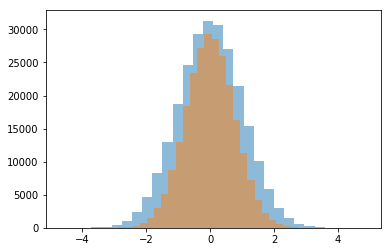

In [4]:
plt.hist(a.flatten(), bins=30, alpha=0.5)
plt.hist(b.flatten(), bins=30, alpha=0.5)
# I think this is where I'm going wrong, I'm trying to control the correlation 
# between a and b without effecting the distribution of b 

# second attempt

In [5]:
mean = 0.0
std = 2.0

means = [mean, mean]
stds = [std, std]
corr = alpha
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 
arrs = np.random.multivariate_normal(means, cov=covs, size=(N,N))
a = arrs[...,0]
b = arrs[...,1]

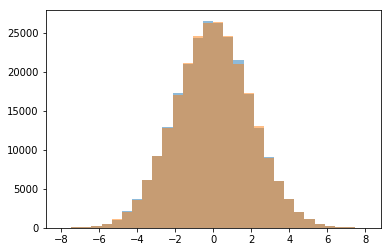

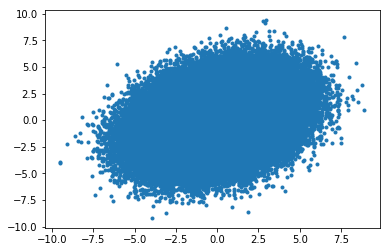

In [6]:
plt.hist(a.flatten(), bins=30, alpha=0.5, range=(-stds[0]*4, stds[0]*4))
plt.hist(b.flatten(), bins=30, alpha=0.5, range=(-stds[0]*4, stds[0]*4))

plt.figure()
plt.scatter(a.flatten(), b.flatten(), marker='.')

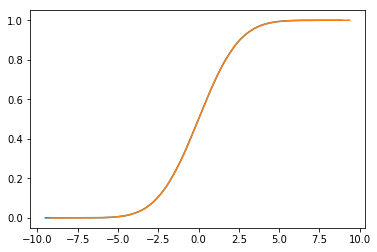

In [7]:
def ecdf(v):
    x = np.sort(v)
    
    y = np.linspace(0, 1, len(v))
    plt.plot(x, y)
ecdf(a.flatten())
ecdf(b.flatten())

In [8]:
def generate_a_and_b_dists(alpha, mean=0.0, std=2.0):

    means = [mean, mean]
    stds = [std, std]
    corr = alpha
    covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
            [stds[0]*stds[1]*corr,           stds[1]**2]] 
    arrs = np.random.multivariate_normal(means, cov=covs, size=(N,N))
    a = arrs[...,0]
    b = arrs[...,1]
    
    return a, b

In [9]:
a, b = generate_a_and_b_dists(alpha=0.0)

In [10]:
def eta(a_, b_, mask):
    b_s_mean = b_[mask].mean()
    a_s_mean = a_[mask].mean()
    b_e_mean = b_[~mask].mean()
    a_e_mean = a_[~mask].mean()
    sigma = np.count_nonzero(mask)/(N*N)
    
    ab_mean = (a_*b_).mean()
    
    return (sigma*a_s_mean*b_s_mean + (1-sigma)*a_e_mean*b_e_mean)/ab_mean

In [11]:
def person(a, b):
    return (a*b).mean()/np.sqrt((a*a).mean())/np.sqrt((b*b).mean())

In [12]:
m = b > 0.1
eta(a,a,m), eta(b,b,m), eta(a,b,m), person(a,b)

(3.868458508095141e-06,
 0.635766847745466,
 1.9533846577508416,
 -0.0007141569304600886)

In [13]:
ds = xr.Dataset(
    dict(
        alpha=np.linspace(0, 1., 10),
        b_crit=np.linspace(b.min(), b.max(), 10),
    )
)
ds

<xarray.Dataset>
Dimensions:  (alpha: 10, b_crit: 10)
Coordinates:
  * alpha    (alpha) float64 0.0 0.1111 0.2222 0.3333 ... 0.7778 0.8889 1.0
  * b_crit   (b_crit) float64 -9.674 -7.617 -5.561 -3.504 ... 4.723 6.78 8.836
Data variables:
    *empty*

In [14]:
import itertools
import tqdm

def apply_all(ds, fn, dims=None):
    """
    Use coordinate dims in ds to provide arguments to fn
    """
    if dims is None:
        dims = ds.coords.keys()

    args = list(itertools.product(*[ds[d].values for d in dims]))
    def process(**kwargs):
        da = fn(**kwargs)
        if da is not None:
            for k, v in kwargs.items():
                da.coords[k] = v
            da = da.expand_dims(kwargs.keys())
        return da

    
    data = [process(**dict(zip(dims,a))) for a in tqdm.tqdm_notebook(args)]
    
    if all([da is None for da in data]):
        return None
    else:
        return xr.merge(data).squeeze()

In [15]:
def run(alpha, b_crit):
    a, b = generate_a_and_b_dists(alpha=alpha)

    m = b > 0.1

    return xr.Dataset(
        dict(
            eta_aa=eta(a,a,m), 
            eta_bb=eta(b,b,m),
            eta_ab=eta(a,b,m), 
            person=person(a,b)
        ),
    )

In [16]:
ds_out = apply_all(ds=ds, fn=run)

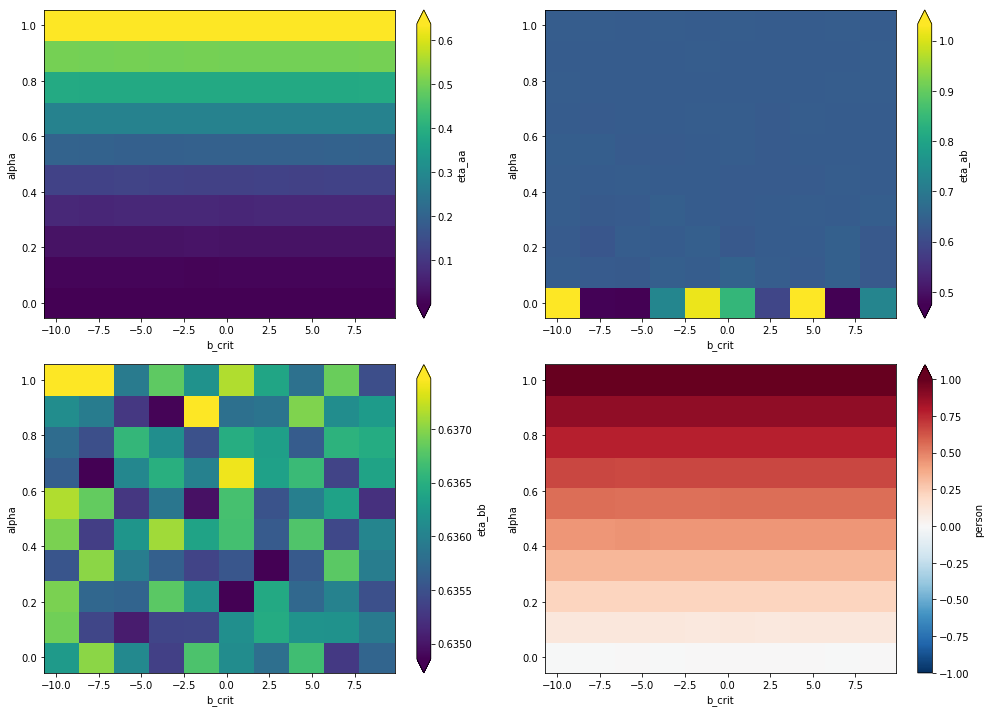

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,10))

ds_out.eta_aa.plot(ax=axes[0][0], robust=True)
ds_out.eta_bb.plot(ax=axes[1][0], robust=True)
ds_out.eta_ab.plot(ax=axes[0][1], robust=True)
ds_out.person.plot(ax=axes[1][1], robust=True)
plt.tight_layout()